**MODEL**-CNN-BiLSTM




**OPTIMIZER**-Lazy Adam




**LEARNING RATE**-10^-2




**DROPOUT** -0.2



**LSTM LAYER**-320



**ACTIVATION**-swish




**BATCH SIZE**-64




**FILTER**-32 32



---









In [ ]:
pip install --upgrade tensorflow tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.3 MB/s eta 0:00:00


In [ ]:
pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 3.5 MB/s eta 0:00:00


In [ ]:
pip install -q -U tensorflow-addons

In [ ]:
import time
start_time=time.time()

Import necessary libraries


In [ ]:
import warnings
import numpy as np
import pandas as pd
import tensorflow
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow_addons.optimizers import LazyAdam
from keras.layers import Dropout

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


LOAD DATA


In [ ]:
train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

One-hot Encoding

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv', parse_dates=['date'])
test = pd.read_csv('test.csv', parse_dates=['date'])

# create new column weekday
train['weekday'] = np.where(train['date'].dt.dayofweek < 5, 0, 1)
test['weekday'] = np.where(test['date'].dt.dayofweek < 5, 0, 1)
# perform one-hot encoding
train = pd.get_dummies(train, columns=['weekday'])
test = pd.get_dummies(test, columns=['weekday'])

#fill sales data with 0 in test set
test['sales'] = 0


MinMax Scaling

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert the 'date' column to datetime format
train['date'] = pd.to_datetime(train['date'])

# Create weekday and weekend indicator variables based on the 'date' column
train['weekday_weekend'] = np.where(train['date'].dt.weekday < 5, 'weekday', 'weekend')

# Select columns to be scaled
val_cols = ['store', 'item']
num_cols = ['sales']

# Scale the numerical columns using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 190))
train[num_cols] = scaler.fit_transform(train[num_cols])

# Add the 'date', 'store', and 'item' columns back to the dataset
train = train[['date'] + val_cols + num_cols + ['weekday_weekend']]

**Train** data description


In [ ]:
print(train.describe())
print(train.head())

               store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      42.976427
std         2.872283      14.430878      23.689252
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      24.675325
50%         5.500000      25.500000      38.658009
75%         8.000000      38.000000      57.575758
max        10.000000      50.000000     190.000000
        date  store  item      sales weekday_weekend
0 2013-01-01      1     1  10.692641         weekday
1 2013-02-01      1     1   9.047619         weekday
2 2013-03-01      1     1  11.515152         weekday
3 2013-04-01      1     1  10.692641         weekday
4 2013-05-01      1     1   8.225108         weekday


In [ ]:
import pandas as pd
# sort the 'date' column in each DataFrame in descending order
train = train.sort_values('date', ascending=True)
test = test.sort_values('date', ascending=True)

# extract the latest date from each DataFrame
train_last_date = train.iloc[-1]['date']
test_last_date = test.iloc[-1]['date']

# convert latest dates to datetime objects and format them as strings
train_last_date = pd.to_datetime(train_last_date).strftime('%Y-%m-%d')
test_last_date = pd.to_datetime(test_last_date).strftime('%Y-%m-%d')

In [ ]:
# Print minimum and maximum date of train set
print("Train set date range: {} to {}".format(train['date'].min(), train['date'].max()))

# Print minimum and maximum date of test set
print("Test set date range: {} to {}".format(test['date'].min(), test['date'].max()))

Train set date range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Test set date range: 2018-01-01 00:00:00 to 2018-12-03 00:00:00


In [ ]:
# print the latest dates and the number of days between them
print("Train last date:", train_last_date)
print("Test last date:", test_last_date)
lag_size = (pd.to_datetime(test_last_date) - pd.to_datetime(train_last_date)).days
print("Number of days between train and test last dates:", lag_size)


Train last date: 2017-12-31
Test last date: 2018-12-03
Number of days between train and test last dates: 337


In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [ ]:
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
fig = go.Figure(data=[daily_sales_sc],layout=layout)
fig.show(renderer="colab")

In [ ]:
import plotly.io as pio
pio.renderers.default='notebook'

Reduce training set with the last year alone

In [ ]:
train = train[(train['date'] >= '2017-01-01')]
print(train.head())

             date  store  item      sales weekday_weekend
447005 2017-01-01      5    25  54.285714         weekend
574825 2017-01-01      5    32  23.852814         weekend
708123 2017-01-01      8    39  34.545455         weekend
753773 2017-01-01      3    42  25.497835         weekend
547435 2017-01-01     10    30  45.238095         weekend


Rearrange datasets to apply shift methods


In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,15.627706
1,1,1,2017-01-02,12.337662
2,1,1,2017-01-03,13.160173
3,1,1,2017-01-04,21.385281
4,1,1,2017-01-05,12.337662


Conversion of pandas data into supervised data

In [ ]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

forecast 90 days with current timesteps


In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+337),store(t+337),sales(t+337)
29,1.0,1.0,15.627706,1.0,1.0,12.337662,1.0,1.0,13.160173,1.0,...,13.160173,1.0,1.0,19.740260,1,1,7.402597,1.0,2.0,18.095238
30,1.0,1.0,12.337662,1.0,1.0,13.160173,1.0,1.0,21.385281,1.0,...,19.740260,1.0,1.0,7.402597,1,1,13.982684,1.0,2.0,26.320346
31,1.0,1.0,13.160173,1.0,1.0,21.385281,1.0,1.0,12.337662,1.0,...,7.402597,1.0,1.0,13.982684,1,1,12.337662,1.0,2.0,33.722944
32,1.0,1.0,21.385281,1.0,1.0,12.337662,1.0,1.0,23.852814,1.0,...,13.982684,1.0,1.0,12.337662,1,1,13.982684,1.0,2.0,20.562771
33,1.0,1.0,12.337662,1.0,1.0,23.852814,1.0,1.0,25.497835,1.0,...,12.337662,1.0,1.0,13.982684,1,1,18.917749,1.0,2.0,33.722944


drop items other than the shifted

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

Remove unwanted columns


In [ ]:
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

train validation split

In [ ]:
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100598, 30)
Validation set shape (67066, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
104547,51.818182,51.818182,64.155844,29.610390,60.865801,68.268398,50.995671,37.835498,53.463203,45.238095,...,36.190476,38.658009,54.285714,39.480519,24.675325,26.320346,59.220779,51.818182,55.930736,44.415584
67218,14.805195,21.385281,18.095238,25.497835,25.497835,38.658009,33.722944,37.835498,47.705628,28.787879,...,30.432900,8.225108,14.805195,22.207792,24.675325,24.675325,18.917749,29.610390,18.095238,24.675325
171431,37.012987,29.610390,27.142857,18.917749,29.610390,29.610390,22.207792,31.255411,20.562771,27.142857,...,26.320346,35.367965,18.917749,23.852814,27.965368,32.077922,10.692641,13.982684,25.497835,24.675325
115475,27.142857,23.030303,27.965368,31.255411,30.432900,32.077922,26.320346,23.030303,25.497835,25.497835,...,32.900433,37.012987,32.077922,27.142857,33.722944,15.627706,32.077922,44.415584,31.255411,24.675325
124345,52.640693,74.848485,80.606061,53.463203,62.510823,59.220779,55.108225,49.350649,79.783550,55.108225,...,53.463203,82.251082,76.493506,51.818182,63.333333,43.593074,67.445887,32.077922,40.303030,46.060606


In [ ]:
from keras import optimizers
epochs = 200
batch = 64
lr = 0.01

For CNN parameters(samples,timesteps,features)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100598, 30, 1)
Validation set shape (67066, 30, 1)


In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Reshape, TimeDistributed
from keras import optimizers
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=32, kernel_size=2, activation='swish', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='swish'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1))
from tensorflow_addons.optimizers import LazyAdam
opt = LazyAdam(lr)
model_cnn.compile(loss='mse', optimizer=opt)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 32)            96        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 14, 32)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 50)                22450     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

BiLstm

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(320, activation='swish'), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_bilstm.add(Dense(1))
from tensorflow_addons.optimizers import LazyAdam
opt = LazyAdam(lr)
model_bilstm.compile(loss='mse', optimizer=opt)
model_bilstm.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 640)              824320    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 641       
                                                                 
Total params: 824,961
Trainable params: 824,961
Non-trainable params: 0
_________________________________________________________________


CNN-BiLSTM [sample,subsequences,timesteps,features]

In [ ]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100598, 2, 15, 1)
Validation set shape (67066, 2, 15, 1)


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed, Bidirectional, LSTM, Dense

model_cnn_bilstm = Sequential()
model_cnn_bilstm.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='swish'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_bilstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_bilstm.add(TimeDistributed(Flatten()))
model_cnn_bilstm.add(Bidirectional(LSTM(320, activation='swish')))
model_cnn_bilstm.add(Dropout(0.2))
model_cnn_bilstm.add(Dense(1))
model_cnn_bilstm.compile(loss='mse', optimizer= tfa.optimizers.LazyAdam())
model_cnn_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 15, 32)     64        
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 7, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 224)        0         
 tributed)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 640)              1395200   
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 640)              

In [ ]:
cnn_bilstm_history = model_cnn_bilstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/200
3144/3144 - 57s - loss: 358.3472 - val_loss: 358.2732 - 57s/epoch - 18ms/step
Epoch 2/200
3144/3144 - 46s - loss: 347.4454 - val_loss: 342.5627 - 46s/epoch - 15ms/step
Epoch 3/200
3144/3144 - 46s - loss: 339.7747 - val_loss: 322.5884 - 46s/epoch - 15ms/step
Epoch 4/200
3144/3144 - 50s - loss: 328.8693 - val_loss: 314.7691 - 50s/epoch - 16ms/step
Epoch 5/200
3144/3144 - 50s - loss: 324.2714 - val_loss: 312.7877 - 50s/epoch - 16ms/step
Epoch 6/200
3144/3144 - 45s - loss: 319.4593 - val_loss: 311.3763 - 45s/epoch - 14ms/step
Epoch 7/200
3144/3144 - 44s - loss: 316.6479 - val_loss: 325.8981 - 44s/epoch - 14ms/step
Epoch 8/200
3144/3144 - 46s - loss: 314.0976 - val_loss: 306.7456 - 46s/epoch - 14ms/step
Epoch 9/200
3144/3144 - 45s - loss: 311.7725 - val_loss: 305.6482 - 45s/epoch - 14ms/step
Epoch 10/200
3144/3144 - 44s - loss: 310.1013 - val_loss: 304.2781 - 44s/epoch - 14ms/step
Epoch 11/200
3144/3144 - 46s - loss: 308.1265 - val_loss: 303.5612 - 46s/epoch - 15ms/step
Epoch 12

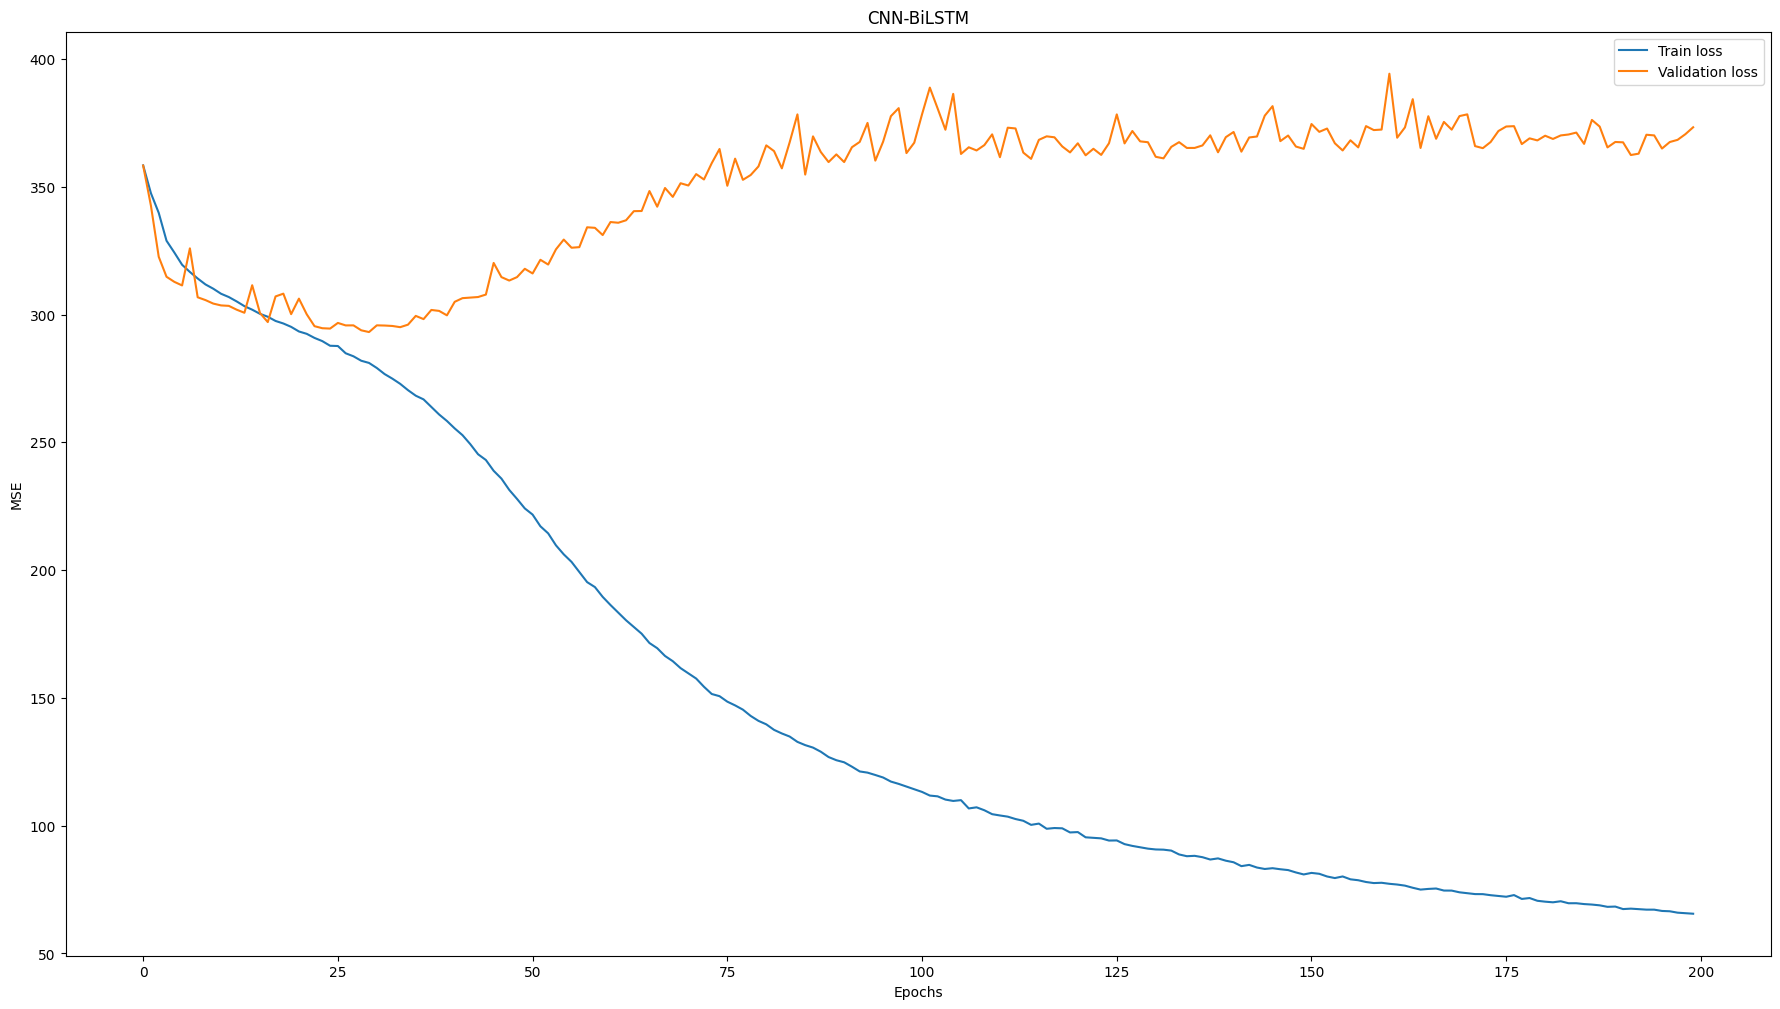

In [ ]:
fig, ax4 = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(22,12))

ax4.plot(cnn_bilstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_bilstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-BiLSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

In [ ]:
cnn_bilstm_train_pred = model_cnn_bilstm.predict(X_train_series_sub)
cnn_bilstm_valid_pred = model_cnn_bilstm.predict(X_valid_series_sub)
end_time=time.time()

print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_bilstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_bilstm_valid_pred)))

Calculating Performance measures

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
mae = mean_absolute_error(Y_train, cnn_bilstm_train_pred)
mape = mean_absolute_percentage_error(Y_train, cnn_bilstm_train_pred) * 100
r2 = r2_score(Y_train, cnn_bilstm_train_pred)
execution_time=end_time-start_time

# Print the results
print("MAE: {:.4f}".format(mae))
print("MAPE: {:.2f}%".format(mape))
print("R-squared: {:.4f}".format(r2))
print("Execution time",execution_time)